In [205]:
# %load ~/my_imports.py
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime
import re

pd.set_option("display.max_rows", 1000)
pd.set_option("max_columns", 100)
pd.set_option("max_colwidth",10000)
import requests 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn import metrics

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from itertools import combinations

pd.set_option('display.float_format', lambda x: '%.3f' % x)
from sklearn.ensemble import RandomForestClassifier

# to do
- clip
- dummy for all column 
    - if bonus	deferral_payments	deferred_income	director_fees all 0, no chance
    - non of poi get director_fees, loan_advances (except 1 person),	restricted_stock_deferred, other	restricted_stock	salary
    - all poi has values for total_payments	total_stock_value
- dummy for is email or not
- intersection of dummies of columns
- for poi, if to_message and from_message is not null, from_poi_to_this_person	from_this_person_to_poi	shared_receipt_with_poi will not be null
- try knn as the data volume is small, knn is vulerable of the weight, as it doesn't know which variable is more important, so use the importance from xgboost

# get files

In [137]:
file_path = '3rd-ml100marathon-midterm/'
train_data = pd.read_csv(file_path+'train_data.csv')
test_X = pd.read_csv(file_path+'test_features.csv')

In [138]:
train_X = train_data.drop('poi',axis=1)
train_Y = train_data['poi']

In [140]:
num_train = len(train_Y)

In [156]:
df = pd.concat([train_X,test_X],ignore_index=True)

In [160]:
df['train_test_type'] = ['train' if x <num_train else 'test' for x in list(df.index)] 

In [173]:
# def get_train_test_type_sub(raw_y):
#     if raw_y==1:
#         return 'train_'
df['train_test_type_sub'] = ['train_poi' if x ==1 else 'train_not_poi' for x in list(train_Y)] + ['test']*33

In [161]:
df.train_test_type.value_counts()

train    113
test      33
Name: train_test_type, dtype: int64

In [174]:
df.train_test_type_sub.value_counts()

train_not_poi    100
test              33
train_poi         13
Name: train_test_type_sub, dtype: int64

# EDA before feature engineering

In [7]:
print(train_Y.sum(),len(train_Y))

13 113


In [163]:
def get_num_features(data):
    numeric_features = []
    for dtype, feature in zip(data.dtypes, data.columns):
        if dtype == 'float64' or dtype == 'int64':
            numeric_features.append(feature)
    return numeric_features

num_features = get_num_features(df)

In [336]:
# train_Y
# 0-12 true

In [338]:
train_X.columns

Index(['name', 'bonus', 'deferral_payments', 'deferred_income',
       'director_fees', 'email_address', 'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
       'loan_advances', 'long_term_incentive', 'other', 'restricted_stock',
       'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
       'to_messages', 'total_payments', 'total_stock_value'],
      dtype='object')

In [337]:
train_X[0:13].bonus.sum()

21100000.0

In [332]:
test_X.bonus.sum()

124693618.0

In [330]:
test_X.sort_values('bonus',ascending=False)

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
20,TOTAL,97343619.000,32083396.000,-27992891.000,1398517.000,NaN,311764000.000,5235198.000,nan,nan,nan,83925000.000,48521928.000,42667589.000,130322299.000,-7576788.000,26704229.000,nan,nan,309886585.000,434509511.000
0,BELDEN TIMOTHY N,5249999.000,2144013.000,-2334434.000,nan,tim.belden@enron.com,953136.000,17355.000,484.000,228.000,108.000,nan,nan,210698.000,157569.000,nan,213999.000,5521.000,7991.000,5501630.000,1110705.000
3,DELAINEY DAVID W,3000000.000,nan,nan,nan,david.delainey@enron.com,2291113.000,86174.000,3069.000,66.000,609.000,nan,1294981.000,1661.000,1323148.000,nan,365163.000,2097.000,3093.000,4747979.000,3614261.000
32,MCMAHON JEFFREY,2600000.000,nan,nan,nan,jeffrey.mcmahon@enron.com,1104054.000,137108.000,48.000,58.000,26.000,nan,694862.000,297353.000,558801.000,nan,370448.000,2228.000,2355.000,4099771.000,1662855.000
21,FALLON JAMES B,2500000.000,nan,nan,nan,jim.fallon@enron.com,940257.000,95924.000,75.000,42.000,37.000,nan,374347.000,401481.000,1392142.000,nan,304588.000,1604.000,1755.000,3676340.000,2332399.000
6,FREVERT MARK A,2000000.000,6426990.000,-3367011.000,nan,mark.frevert@enron.com,10433518.000,86987.000,21.000,242.000,6.000,2000000.000,1617011.000,7427621.000,4188667.000,nan,1060932.000,2979.000,3275.000,17252530.000,14622185.000
5,HICKERSON GARY J,1700000.000,nan,nan,nan,gary.hickerson@enron.com,nan,98849.000,27.000,40.000,1.000,nan,69223.000,1936.000,441096.000,nan,211788.000,900.000,1320.000,2081796.000,441096.000
2,HANNON KEVIN P,1500000.000,nan,-3117011.000,nan,kevin.hannon@enron.com,5538001.000,34039.000,32.000,32.000,21.000,nan,1617011.000,11350.000,853064.000,nan,243293.000,1035.000,1045.000,288682.000,6391065.000
29,SHERRIFF JOHN R,1500000.000,nan,nan,nan,john.sherriff@enron.com,1835558.000,nan,92.000,28.000,23.000,nan,554422.000,1852186.000,1293424.000,nan,428780.000,2103.000,3187.000,4335388.000,3128982.000
1,BOWEN JR RAYMOND M,1350000.000,nan,-833.000,nan,raymond.bowen@enron.com,nan,65907.000,27.000,140.000,15.000,nan,974293.000,1621.000,252055.000,nan,278601.000,1593.000,1858.000,2669589.000,252055.000


In [10]:
train_X.describe(include='all')

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,113,61.000,28.000,34.000,13.000,83,81.000,73.000,65.000,65.000,65.000,2.000,49.000,69.000,82.000,10.000,73.000,65.000,65.000,96.000,98.000
unique,113,nan,nan,nan,nan,83,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,PIPER GREGORY F,nan,nan,nan,nan,richard.dimichele@enron.com,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,1,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,1147436.393,634437.429,-462566.353,89397.846,NaN,2985080.778,51040.548,711.323,64.800,40.092,40962500.000,792617.102,447177.377,1294854.793,-221885.700,273902.521,1111.369,2156.062,2590977.292,3527135.796
std,NaN,1505189.036,860364.586,809539.169,41143.391,NaN,6004173.616,47596.682,2074.498,91.863,88.901,57364037.624,950464.489,1341563.812,2498335.269,205191.374,171664.685,1165.852,2811.677,10566445.776,7182997.185
min,NaN,70000.000,-102500.000,-3504386.000,3285.000,NaN,3285.000,148.000,12.000,0.000,0.000,400000.000,71023.000,2.000,44093.000,-560222.000,477.000,2.000,57.000,148.000,-44093.000
25%,NaN,450000.000,76567.500,-552703.250,101250.000,NaN,400478.000,18834.000,19.000,10.000,0.000,20681250.000,275000.000,972.000,268922.000,-389621.750,206121.000,178.000,517.000,302402.500,421151.750
50%,NaN,750000.000,195190.000,-117534.000,108579.000,NaN,850010.000,41953.000,45.000,28.000,7.000,40962500.000,422158.000,52382.000,462822.500,-139856.500,251654.000,599.000,1088.000,1106740.000,997971.000
75%,NaN,1000000.000,834205.250,-27083.250,112492.000,NaN,2165172.000,59175.000,215.000,88.000,27.000,61243750.000,831809.000,362096.000,966490.500,-77953.250,288589.000,1902.000,2649.000,1985668.250,2493616.000


In [135]:
train_X[train_Y==1].describe(include='all')

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,13,11.000,4.000,7.000,0.000,13,9.000,13.000,9.000,9.000,9.000,1.000,8.000,13.000,12.000,0.000,12.000,9.000,9.000,13.000,13.000
unique,13,nan,nan,nan,nan,13,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,COLWELL WESLEY,nan,nan,nan,nan,ken.rice@enron.com,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,1,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,1918181.818,113864.500,-814452.857,nan,NaN,12975919.333,64890.769,60.444,93.889,18.778,81525000.000,1277758.000,1070825.231,2860721.167,nan,416859.833,1459.000,1995.667,9797536.769,11623994.462
std,NaN,2228482.974,109949.351,1274638.052,nan,NaN,13455053.171,40367.558,43.244,78.588,13.718,nan,1183988.247,2827237.818,4200914.628,nan,325528.783,802.495,1343.545,28254356.835,15681746.600
min,NaN,200000.000,10259.000,-3504386.000,nan,NaN,384728.000,16514.000,16.000,13.000,4.000,81525000.000,71023.000,486.000,126027.000,nan,158403.000,91.000,225.000,91093.000,126027.000
25%,NaN,700000.000,23272.250,-843027.500,nan,NaN,1624396.000,33271.000,36.000,42.000,11.000,81525000.000,356478.000,22122.000,622136.000,nan,236218.000,874.000,905.000,1099100.000,985032.000
50%,NaN,1200000.000,115260.500,-262500.000,nan,NaN,8308552.000,53947.000,40.000,53.000,15.000,81525000.000,1109841.000,150458.000,1116675.000,nan,281758.500,1258.000,1758.000,1587421.000,1920055.000
75%,NaN,1525000.000,205852.750,-122031.000,nan,NaN,19794175.000,99832.000,82.000,123.000,25.000,81525000.000,1782041.250,277464.000,2955324.500,nan,425651.500,2188.000,2598.000,2424083.000,22542539.000


In [131]:
test_X.describe(include='all')

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,33,21.000,11.000,15.000,4.000,28,21.000,22.000,21.000,21.000,21.000,2.000,17.000,24.000,28.000,8.000,22.000,21.000,21.000,29.000,28.000
unique,33,nan,nan,nan,nan,28,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,BHATNAGAR SANJAY,nan,nan,nan,nan,jeff.donahue@enron.com,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,1,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,5937791.333,4209094.909,-2677068.400,418377.750,NaN,17566092.476,300149.409,291.429,65.190,44.762,42962500.000,3423859.882,2275741.792,5329051.143,651780.875,1518798.818,1377.952,1819.429,13326103.138,18137833.250
std,NaN,20979021.325,9442610.012,7096873.194,654707.367,NaN,67461155.238,1102935.726,702.655,71.753,131.354,57929723.049,11631908.377,8737002.343,24521963.117,6506283.556,5628470.162,1222.687,1720.857,57182326.641,81663218.133
min,NaN,100000.000,51365.000,-27992891.000,38346.000,NaN,765920.000,2151.000,12.000,0.000,0.000,2000000.000,69223.000,69.000,-2604490.000,-7576788.000,76399.000,3.000,58.000,2151.000,47304.000
25%,NaN,425000.000,232265.000,-1809217.000,83674.500,NaN,1030329.000,34283.750,25.000,28.000,1.000,22481250.000,350000.000,1651.000,208734.250,-683146.000,219613.500,702.000,807.000,564348.000,985366.000
50%,NaN,1000000.000,564348.000,-235000.000,118324.000,NaN,2027865.000,61817.000,29.000,40.000,12.000,42962500.000,461912.000,74607.000,423547.500,-223782.500,272847.000,1074.000,1607.000,1061827.000,1838142.000
75%,NaN,2000000.000,2637936.500,-129288.000,453027.250,NaN,4160672.000,96182.000,75.000,64.000,21.000,63443750.000,974293.000,331291.500,1300855.000,-70201.500,369283.000,1604.000,2350.000,3676340.000,3250301.750


In [143]:
def plot_box_plot_by_group(data,metric_col,groupby_col):
    plt.figure(figsize=(16,2))
    plt.title('{} by {}'.format(metric_col,groupby_col))
    sns.boxplot(x = metric_col,y=groupby_col,
    data = data[(~data[metric_col].isna())],showfliers=False)

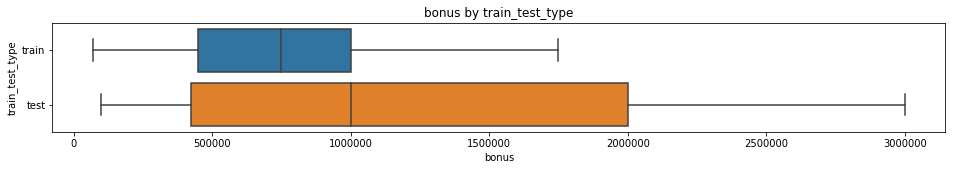

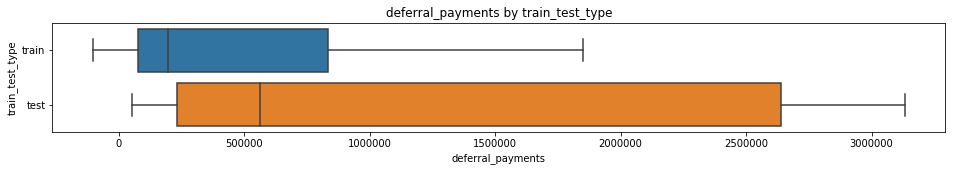

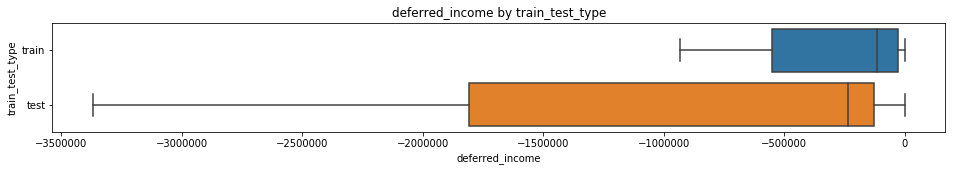

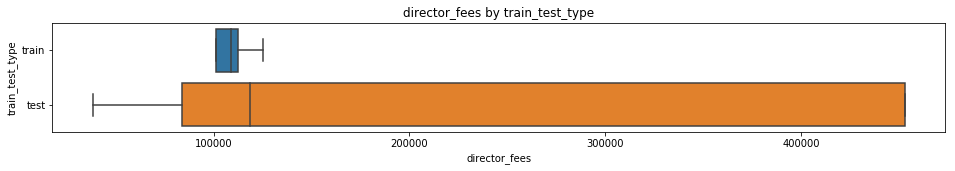

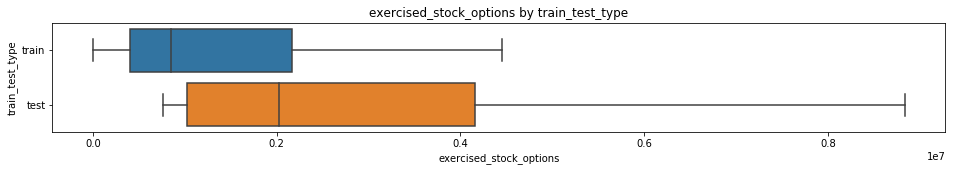

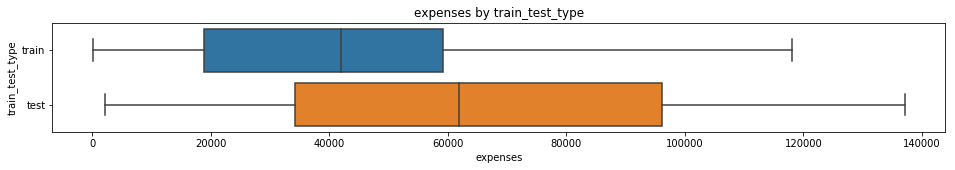

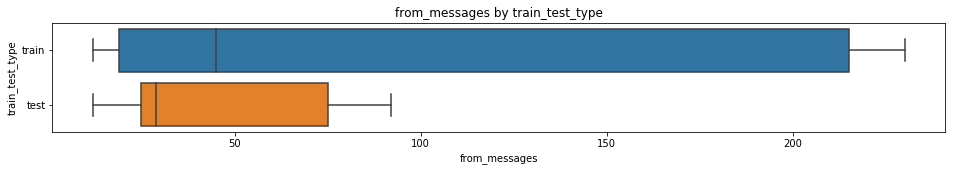

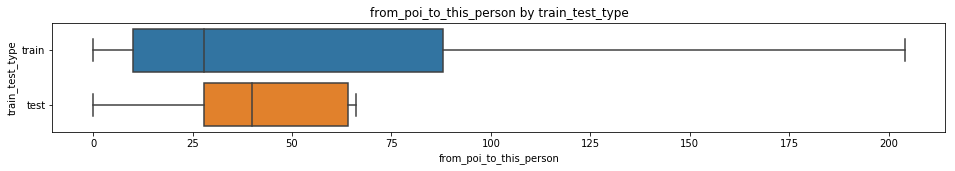

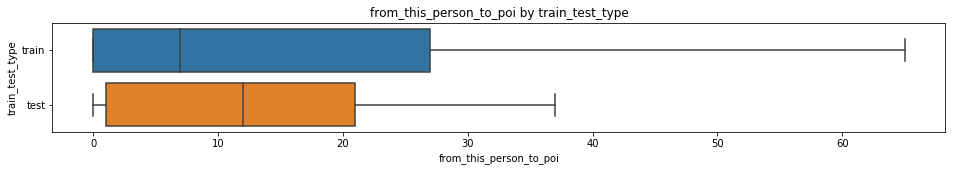

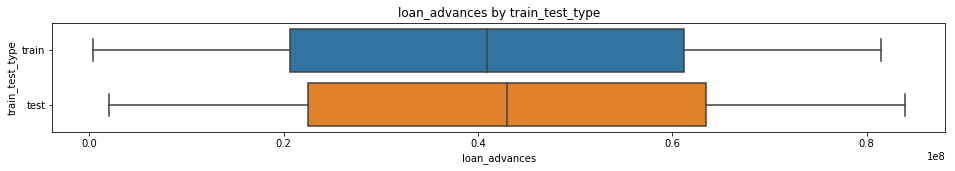

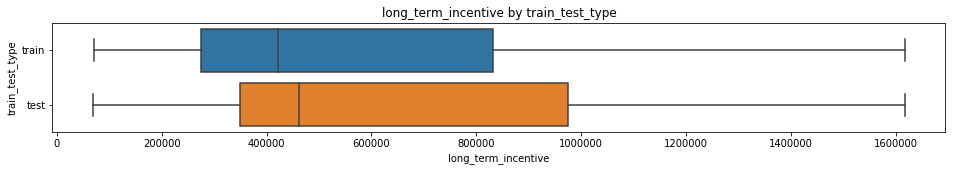

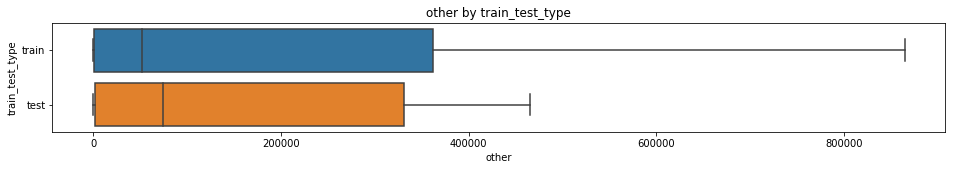

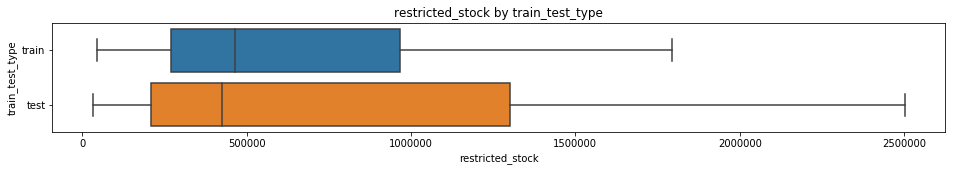

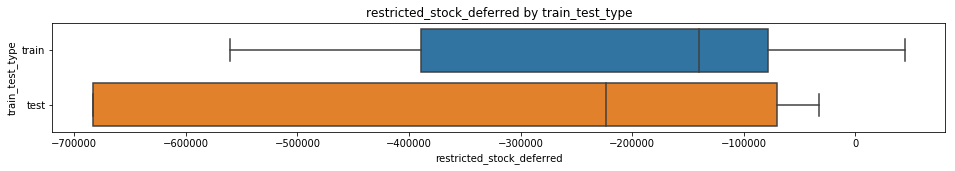

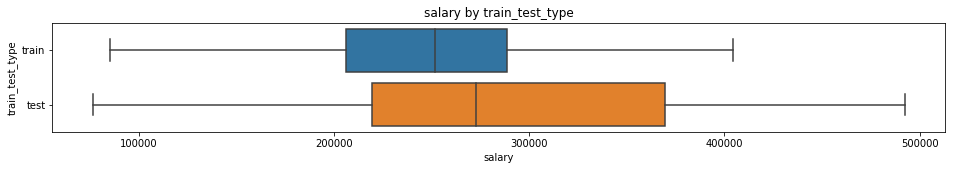

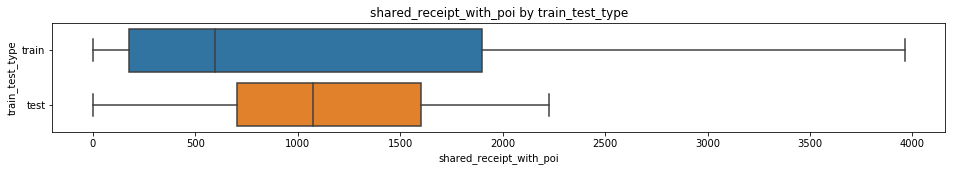

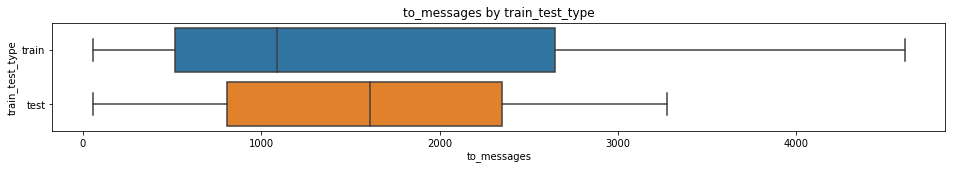

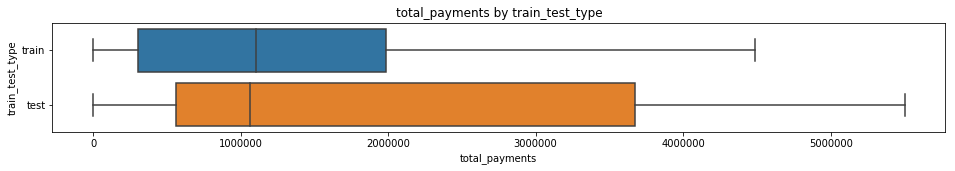

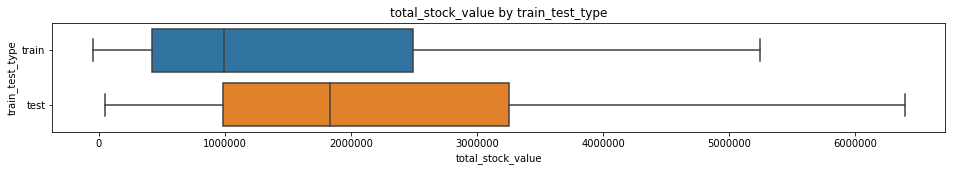

In [164]:
for num_feature in num_features:
    plot_box_plot_by_group(df,num_feature,'train_test_type')

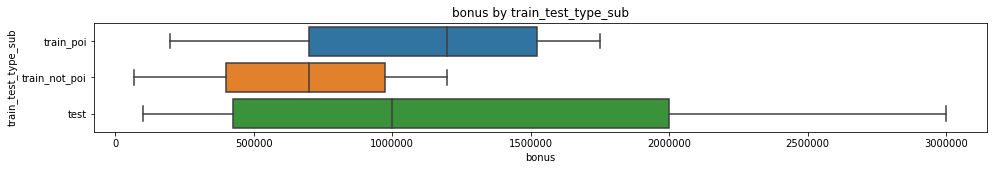

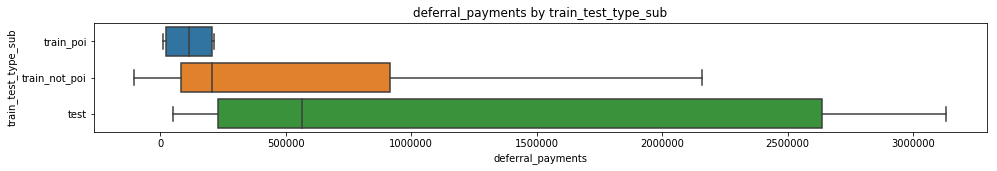

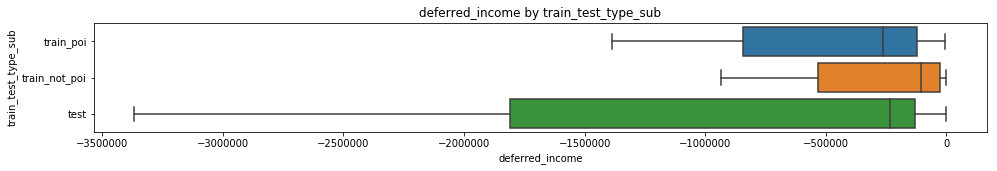

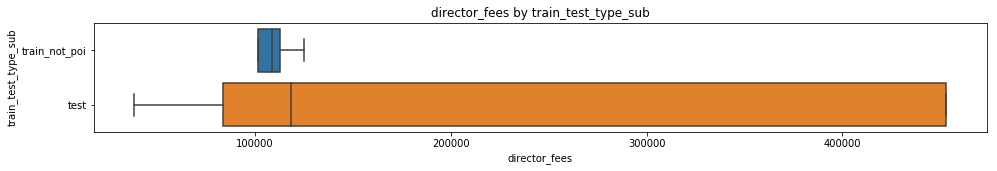

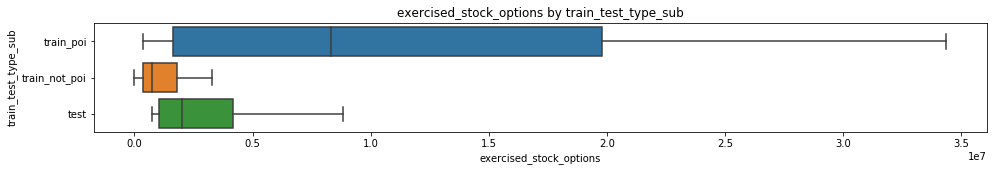

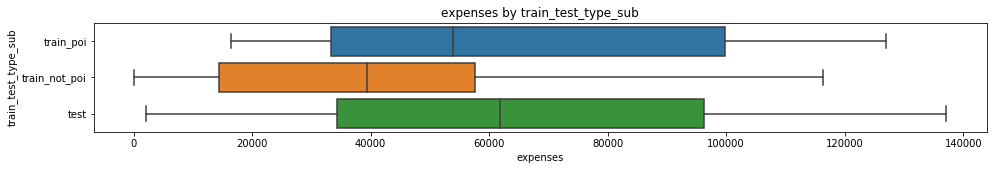

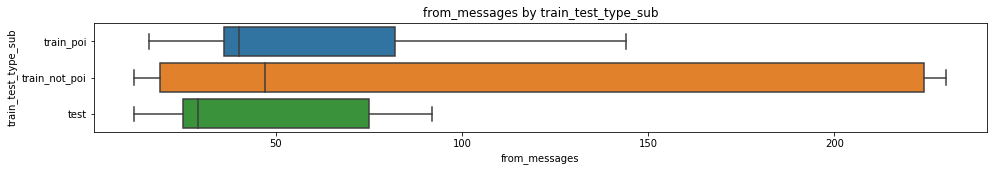

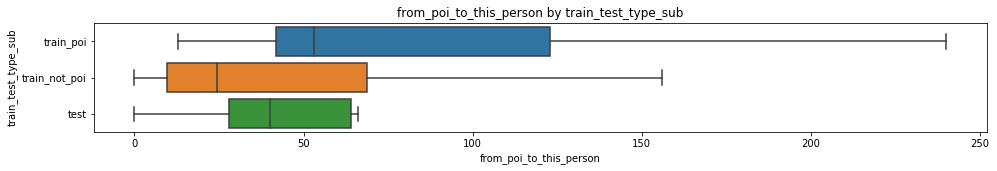

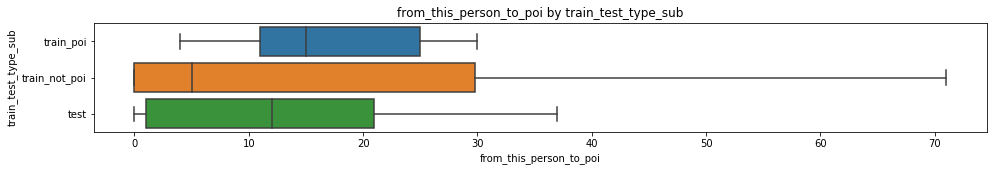

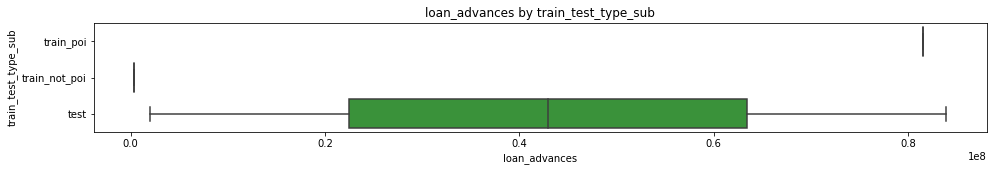

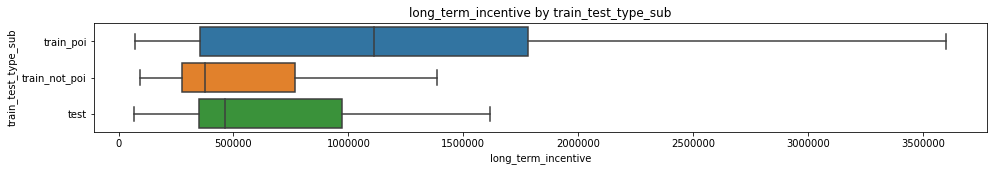

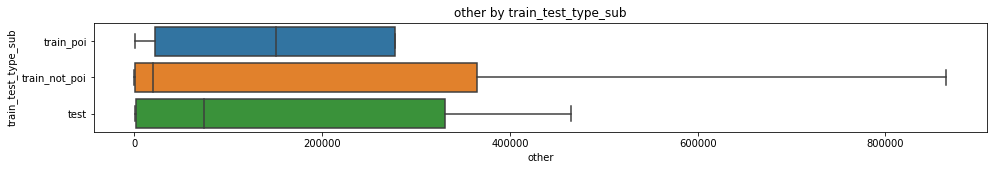

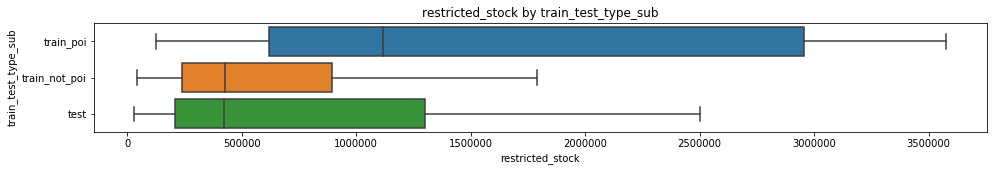

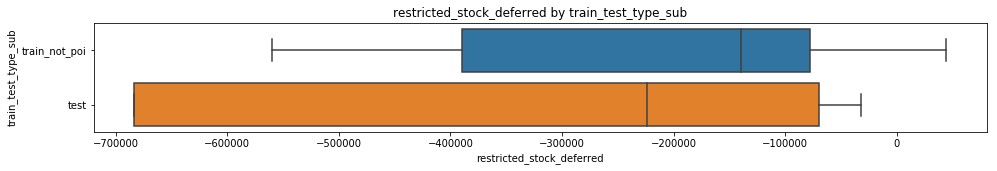

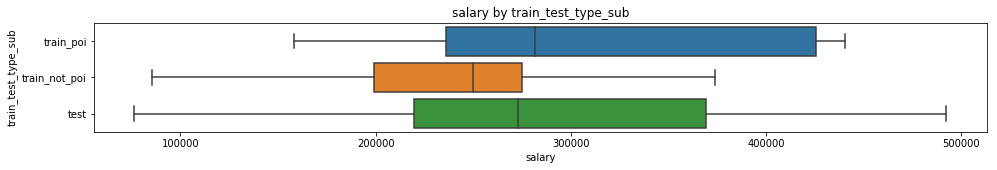

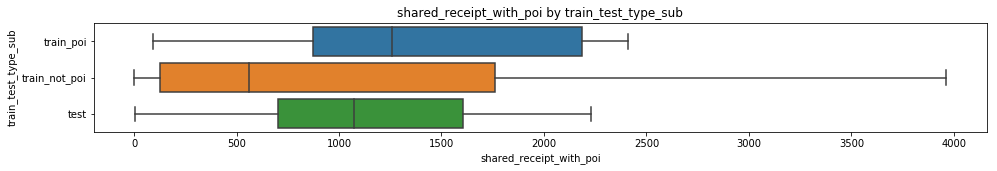

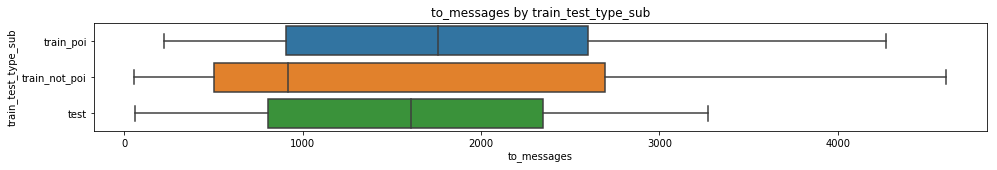

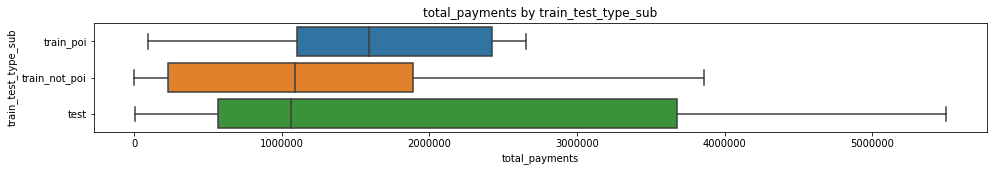

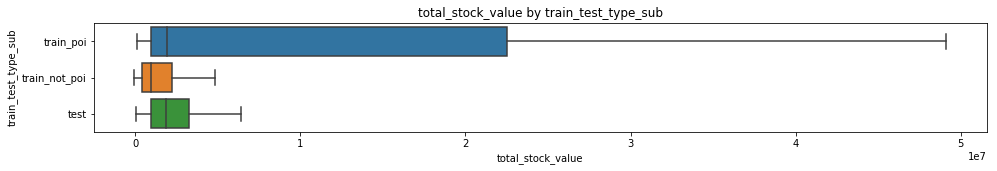

In [175]:
for num_feature in num_features:
    plot_box_plot_by_group(df,num_feature,'train_test_type_sub')

In [181]:
synthetic_df = df[df.train_test_type_sub=='train_poi'].loc[df[df.train_test_type_sub=='train_poi'].index.repeat(9)]


117

In [182]:
synthetic_df = pd.concat([synthetic_df,df[df.train_test_type_sub=='train_not_poi'],df[df.train_test_type_sub=='test']])

In [183]:
synthetic_df.count()[0]

250

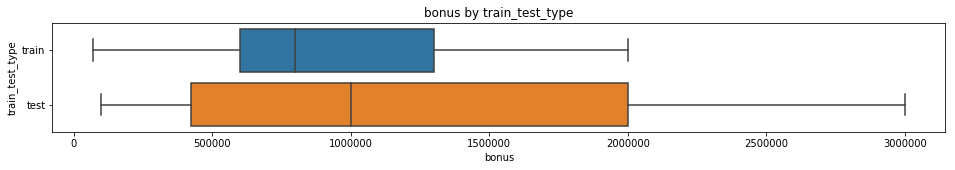

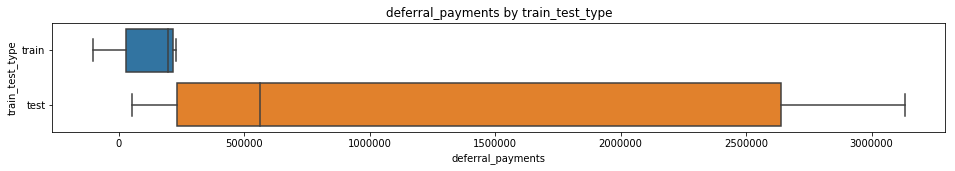

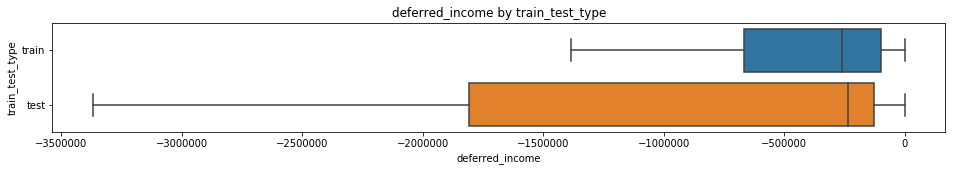

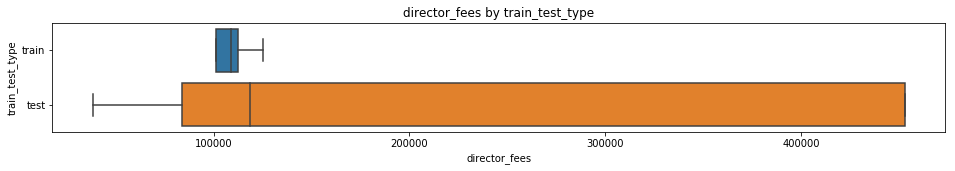

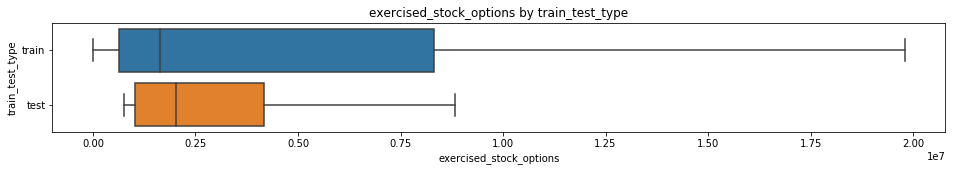

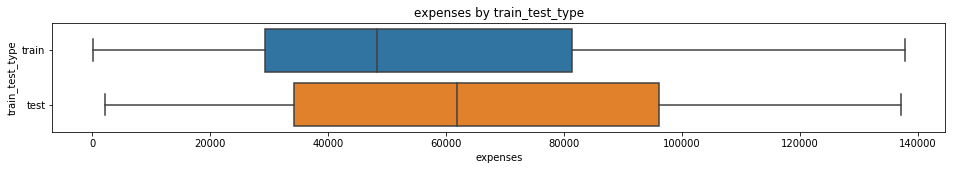

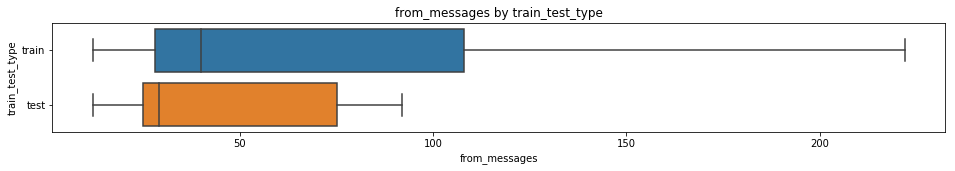

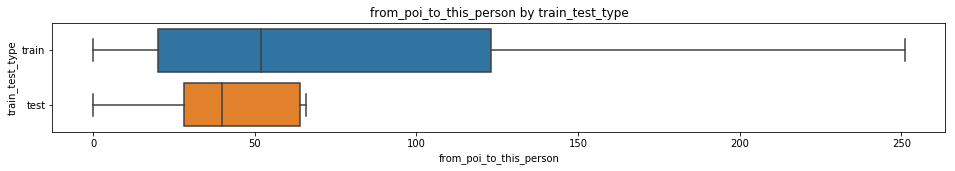

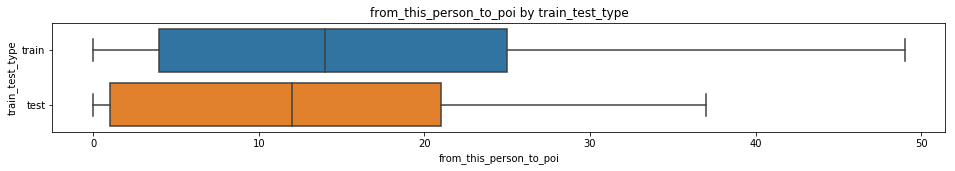

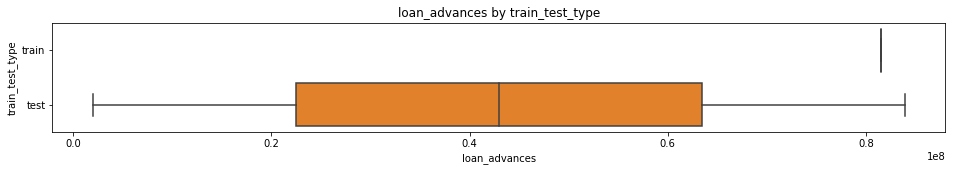

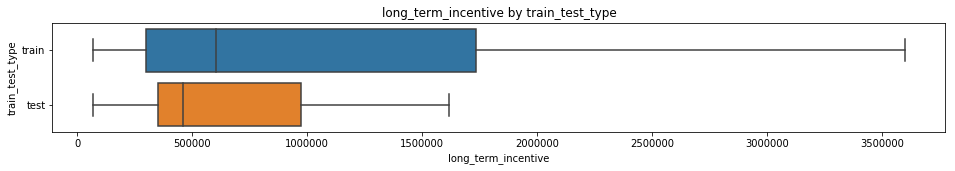

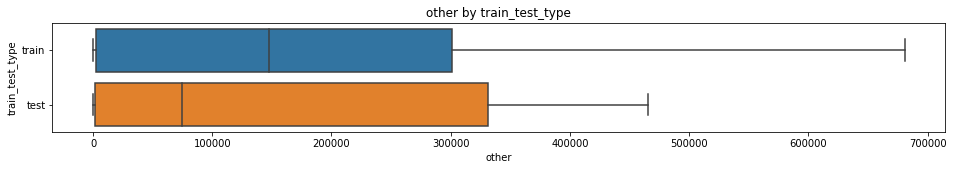

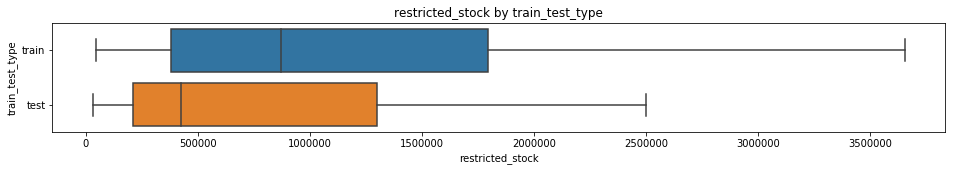

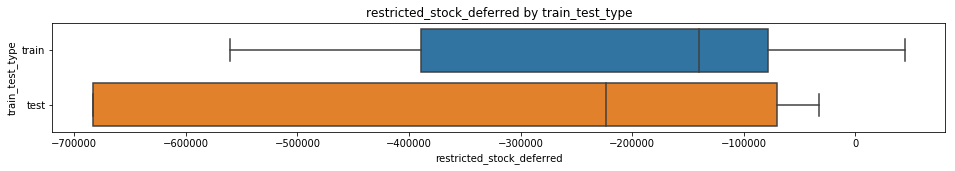

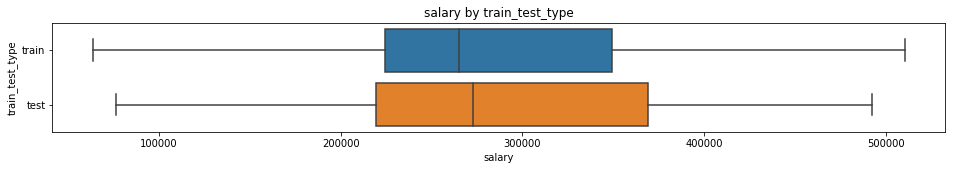

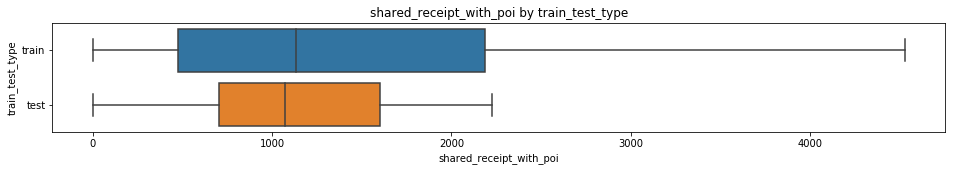

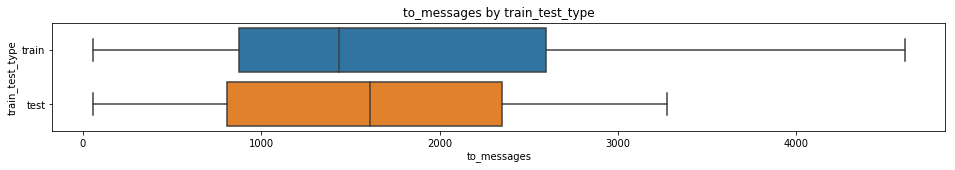

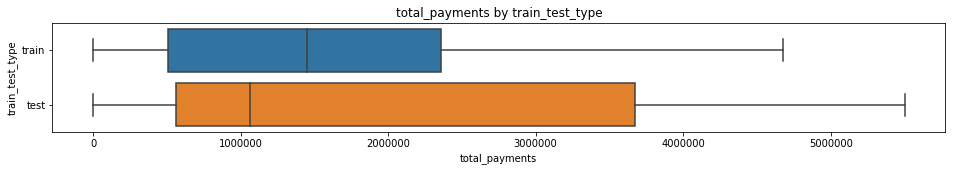

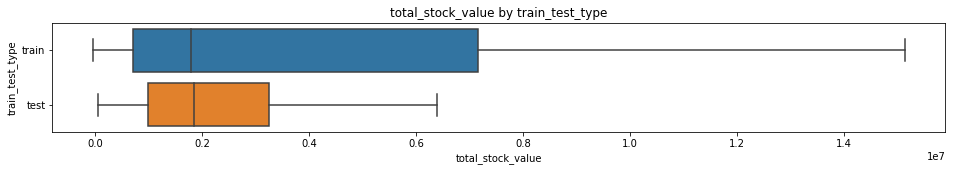

In [184]:
for num_feature in num_features:
    plot_box_plot_by_group(synthetic_df,num_feature,'train_test_type')

In [ ]:
for num_feature in num_features:
    plot_box_plot_by_group(df[train_Y==1],num_feature,'train_test_type')

In [81]:
train_data.head()

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [ ]:
train_data.loc[:,'poi_str'] = train_data['poi'].apply(lambda x: 'yes' if x ==1 else 'no')

In [177]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df[df.train_test_type=='train'])

,Missing Ratio
loan_advances,98.230
restricted_stock_deferred,91.150
director_fees,88.496
deferral_payments,75.221
deferred_income,69.912
long_term_incentive,56.637
bonus,46.018
from_messages,42.478
from_poi_to_this_person,42.478
from_this_person_to_poi,42.478


In [178]:
na_check(df[df.train_test_type=='test'])

,Missing Ratio
loan_advances,93.939
director_fees,87.879
restricted_stock_deferred,75.758
deferral_payments,66.667
deferred_income,54.545
long_term_incentive,48.485
from_this_person_to_poi,36.364
from_poi_to_this_person,36.364
exercised_stock_options,36.364
from_messages,36.364


# data processing

In [120]:
# def replace_na_with_mode(data,cols):
#     for col in cols:
#         data[col] = data[col].fillna(df[col].mode()[0])
#     return data

In [186]:
def replace_na_with_zero(data,cols):
    for col in cols:
        data[col] = data[col].fillna(0)
    return data

In [187]:
df = replace_na_with_zero(df,num_features)

In [188]:
def mark_is_0_or_not(data,cols):
    for col in cols:
        data['has_' +col] = data[col].apply(lambda x: 1 if x>0 else 0)
    return data

In [189]:
df = mark_is_0_or_not(df,num_features)

In [190]:
df['email_address'] = df['email_address'].astype(str)

In [191]:
df['has_email'] = df['email_address'].apply(lambda x: 1 if x.endswith('@enron.com') else 0)

In [192]:
dummy_cols = [i for i in df.columns if i.startswith('has_') ]

In [339]:
# def get_dummy_interactions(data,cols):
#     r_list = range(2,3)
#     for r in r_list:
#         combination_col_to_sum = combinations(cols,r)
#         for col_to_sum in combination_col_to_sum:
#             data['sum'+'_'.join(col_to_sum)] = data[list(col_to_sum)].apply(lambda x: x.sum(),axis=1)
#     return data

In [194]:
def get_dummy_interactions(data,cols):
    r_list = range(2,3)
    for r in r_list:
        combination_col_to_sum = combinations(cols,r)
        for col_to_sum in combination_col_to_sum:
#             print(col_to_sum)
            data['multiple_'+'_'.join(col_to_sum)] = data[list(col_to_sum)].apply(lambda x: np.prod(x) ,axis=1)
    return data

In [195]:
df = get_dummy_interactions(df,dummy_cols)

In [365]:
def get_ratio(numerator,denominator):
    if (denominator == 0) | (denominator==None):
        return 0.0
    else:
        return (0.0+numerator)/denominator

def get_ratios(data,numerator_lists, denominator_col):
    for numerator_col in numerator_lists:
        data['ratio_'+numerator_col+'_by_'+denominator_col] = data.apply(lambda x: get_ratio(x[numerator_col],x[denominator_col]) ,axis=1)
    return data


In [356]:
df['total_compensation'] = df['total_payments']+df['total_stock_value']

In [357]:
payment_cols = ['bonus','deferral_payments','deferred_income','director_fees','expenses','loan_advances','long_term_incentive','other']
stock_cols = ['exercised_stock_options','restricted_stock_deferred','restricted_stock']
tc_cols = ['total_payments','total_stock_value']

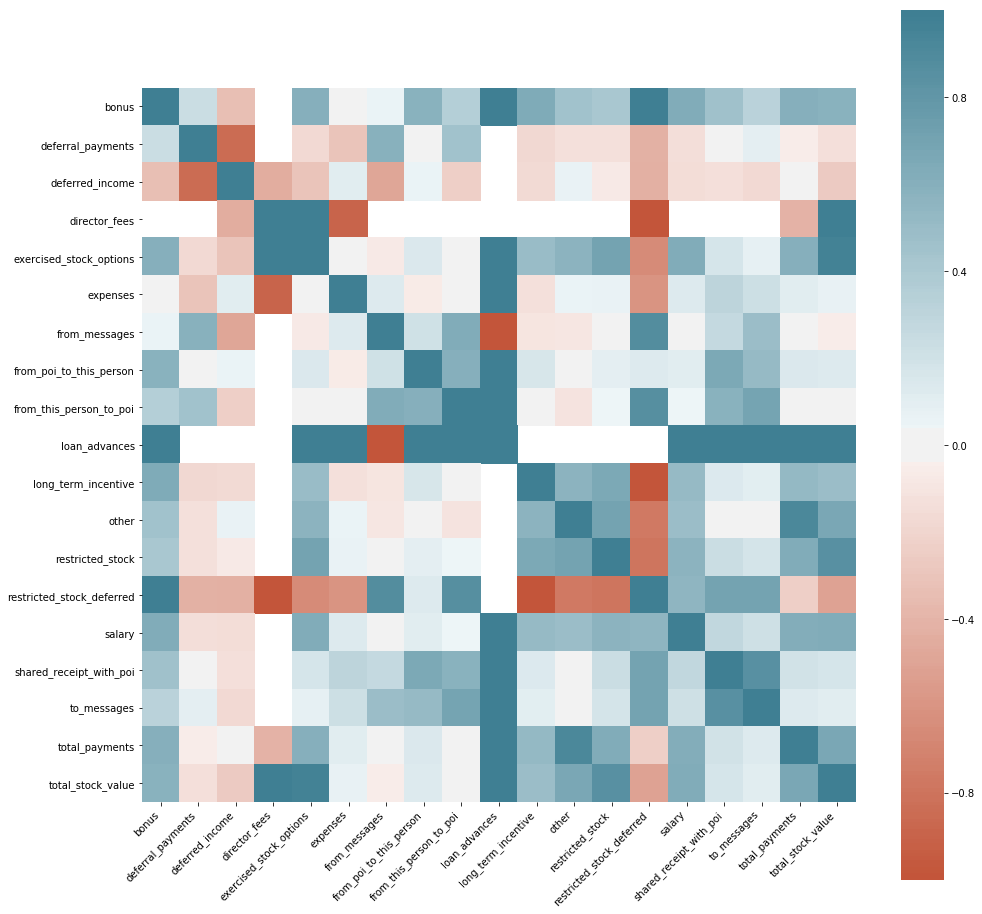

In [353]:
corr = train_X.corr()
fig, ax = plt.subplots(figsize=(16,16))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
# figsize=(15,5)
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [354]:
exclude_cols = ['loan_advances','other']

In [367]:
df = get_ratios(df,payment_cols,'total_payments')

In [368]:
df = get_ratios(df,stock_cols,'total_stock_value')

In [369]:
df = get_ratios(df,tc_cols,'total_compensation')

In [355]:
train_X.columns

Index(['name', 'bonus', 'deferral_payments', 'deferred_income',
       'director_fees', 'email_address', 'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
       'loan_advances', 'long_term_incentive', 'other', 'restricted_stock',
       'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
       'to_messages', 'total_payments', 'total_stock_value'],
      dtype='object')

In [370]:
df = get_ratios(df,['from_poi_to_this_person'],'to_messages')

In [371]:
df = get_ratios(df,['from_this_person_to_poi'],'from_messages')

In [373]:
df['total_messages'] = df['from_messages']+df['to_messages']

In [374]:
df = get_ratios(df,['from_messages','to_messages'],'total_messages')

In [340]:
# def process_standard_scaler(data,cols):
#     data[num_features] = StandardScaler().fit_transform(data[num_features])
#     return data

In [375]:
all_num_features = get_num_features(df)
len(all_num_features)

248

In [32]:
# df = process_standard_scaler(df,all_num_features)

# Treatment for train test mismatch

In [199]:
from sklearn.model_selection import StratifiedKFold

In [230]:
y = df['train_test_type'].apply(lambda x: 0 if x=='test' else 1) #labels
x = df[all_num_features].values 

In [259]:
m = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)
m.fit(x, y)
predictions = m.predict_proba(x)[:, 1]

/Users/ttyoung/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [231]:
m = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)
predictions = np.zeros(y.shape) #creating an empty prediction array

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=100)
for fold, (train_idx, test_idx) in enumerate(skf.split(x, y)):
    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    m.fit(X_train, y_train)
    probs = m.predict_proba(X_test)[:, 1] #calculating the probability
    predictions[test_idx] = probs

/Users/ttyoung/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [260]:
print('ROC-AUC for train and test distributions:', metrics.roc_auc_score(y, predictions))

ROC-AUC for train and test distributions: 0.8640386162510056


In [262]:
fpr, tpr, threshold = metrics.roc_curve(y, predictions)
roc_auc = metrics.auc(fpr, tpr)

In [263]:
print(metrics.auc(y, predictions),metrics.roc_auc_score(y, predictions),metrics.auc(fpr, tpr))

0.7584142948367086 0.8640386162510056 0.8640386162510056


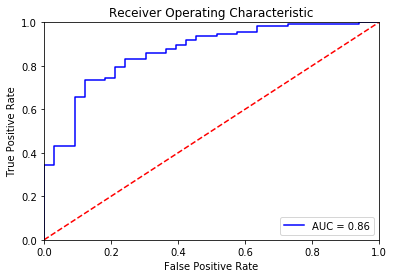

In [264]:

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

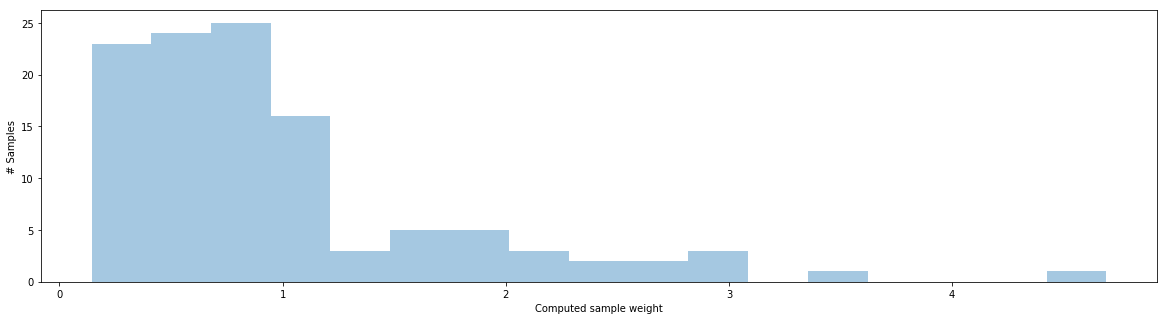

In [265]:
plt.figure(figsize=(20,5))
predictions_train = predictions[:num_train] #filtering the actual training rows
weights = (1./predictions_train) - 1. 
weights /= np.mean(weights) # Normalizing the weights
plt.xlabel('Computed sample weight')
plt.ylabel('# Samples')
sns.distplot(weights, kde=False)

# Model

## randomforest

In [426]:
rf = RandomForestClassifier(max_depth=25, n_estimators=500)

In [427]:
rf.fit(df[:num_train][all_num_features],train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [428]:
y_train_pred_proba_rf = rf.predict_proba(df[:num_train][all_num_features])

In [429]:
new_train = df[:num_train]
new_train['y_train_pred_proba_rf'] = [i[1] for i in y_train_pred_proba_rf]

/Users/ttyoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [430]:
# new_train['y_train_pred_proba_rf']

In [432]:
y_test_pred_proba_rf = rf.predict_proba(df[num_train:][all_num_features])[:,1]

In [435]:
y_test_pred_proba_rf

array([0.384, 0.438, 0.508, 0.084, 0.538, 0.362, 0.698, 0.002, 0.388,
       0.074, 0.036, 0.004, 0.028, 0.   , 0.296, 0.   , 0.098, 0.23 ,
       0.204, 0.016, 0.56 , 0.416, 0.15 , 0.046, 0.06 , 0.13 , 0.106,
       0.042, 0.2  , 0.21 , 0.006, 0.106, 0.406])

In [436]:
predictions_pd = output_prediction(y_test_pred_proba_rf,'Day_051_053_predictions_rf_derived_ratios.csv',
                                   use_proba=True,threshold=None)

In [437]:
predictions_pd


,name,poi
0,BELDEN TIMOTHY N,0.384
1,BOWEN JR RAYMOND M,0.438
2,HANNON KEVIN P,0.508
3,DELAINEY DAVID W,0.084
4,CAUSEY RICHARD A,0.538
5,HICKERSON GARY J,0.362
6,FREVERT MARK A,0.698
7,CHAN RONNIE,0.002
8,DONAHUE JR JEFFREY M,0.388
9,REYNOLDS LAWRENCE,0.074


In [314]:
new_test = df[num_train:]
new_test['y_test_pred_proba_rf'] = [i[1] for i in y_test_pred_proba_rf]

/Users/ttyoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [235]:
# [i[1] for i in y_test_pred_proba_rf]

In [245]:
# feature_importance = np.array(list(zip(all_num_features,map(lambda x: round(x, 4), rf.feature_importances_))))

In [257]:
feature_importance = np.array(list(map(lambda x: round(x, 4), rf.feature_importances_)))
feature_importance.shape

(1369,)

In [236]:
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), all_num_features), 
             reverse=True))

[(0.1583, 'exercised_stock_options'), (0.0986, 'total_stock_value'), (0.0907, 'expenses'), (0.0848, 'other'), (0.0654, 'bonus'), (0.0441, 'salary'), (0.0331, 'restricted_stock'), (0.0307, 'deferred_income'), (0.0258, 'from_messages'), (0.0256, 'total_payments'), (0.023, 'from_poi_to_this_person'), (0.0197, 'shared_receipt_with_poi'), (0.019, 'long_term_incentive'), (0.014, 'to_messages'), (0.0132, 'from_this_person_to_poi'), (0.0098, 'sumhas_bonus_has_expenses_has_from_this_person_to_poi'), (0.0051, 'sumhas_deferral_payments_has_expenses_has_from_this_person_to_poi'), (0.0032, 'deferral_payments'), (0.0029, 'sumhas_expenses_has_from_this_person_to_poi_has_other'), (0.0028, 'sumhas_expenses_has_other_has_email'), (0.0021, 'sumhas_deferral_payments_has_expenses_has_other'), (0.0021, 'sumhas_deferral_payments_has_expenses_has_email'), (0.0021, 'sumhas_deferral_payments_has_exercised_stock_options_has_long_term_incentive'), (0.0019, 'sumhas_deferral_payments_has_expenses_has_long_term_ince

In [253]:
np.array([1,2,3]) * np.array([2,0,1]) 

array([2, 0, 3])

## knn

In [290]:
class get_weights:
    def __call__(self,inputs):
        return inputs * feature_importance

# foo_instance = get_weights()
# foo_instance(np.arange(0,5))

In [306]:
train_x_importance_adjusted_array = np.array(df[:num_train][all_num_features]) * feature_importance

In [307]:
test_x_importance_adjusted_array = np.array(df[num_train:][all_num_features]) * feature_importance

In [291]:
# knn = KNeighborsClassifier(n_neighbors=2, weights=get_weights())

In [328]:
knn = KNeighborsClassifier(n_neighbors=5)

In [329]:
knn.fit(train_x_importance_adjusted_array, train_Y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [333]:
y_train_pred_proba_knn = [i[1] for i in list(knn.predict_proba(train_x_importance_adjusted_array))]
new_train['y_train_pred_proba_knn'] = y_train_pred_proba_knn

/Users/ttyoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [330]:
y_test_pred_proba_knn = [i[1] for i in list(knn.predict_proba(test_x_importance_adjusted_array))]

In [331]:
new_test['y_test_pred_proba_knn'] = y_test_pred_proba_knn

/Users/ttyoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [332]:
new_test[['name','y_test_pred_proba_knn','y_test_pred_proba_rf']]

,name,y_test_pred_proba_knn,y_test_pred_proba_rf
0,BELDEN TIMOTHY N,0.200,0.355
1,BOWEN JR RAYMOND M,0.400,0.393
2,HANNON KEVIN P,0.200,0.331
3,DELAINEY DAVID W,0.000,0.059
4,CAUSEY RICHARD A,0.400,0.445
5,HICKERSON GARY J,0.200,0.391
6,FREVERT MARK A,0.000,0.639
7,CHAN RONNIE,0.000,0.006
8,DONAHUE JR JEFFREY M,0.400,0.136
9,REYNOLDS LAWRENCE,0.000,0.063


In [248]:
feature_importance

array([['bonus', '0.0654'],
       ['deferral_payments', '0.0032'],
       ['deferred_income', '0.0307'],
       ...,
       ['sumhas_to_messages_has_total_payments_has_email', '0.0001'],
       ['sumhas_to_messages_has_total_stock_value_has_email', '0.0'],
       ['sumhas_total_payments_has_total_stock_value_has_email', '0.0']],
      dtype='<U88')

## xgboost

In [376]:
import xgboost as xgb

In [377]:
from xgboost import XGBClassifier

In [378]:
# fit model no training data
model = XGBClassifier(random_state=7)
# model.fit(df[0:num_train][num_features], train_Y)

In [379]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

In [380]:
# 設定要訓練的超參數組合
n_estimators = list(np.random.randint(25,200,20))
max_depth = list(range(1,6))
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, verbose=1,cv=5)

# 開始搜尋最佳參數
grid_result = grid_search.fit(df[0:num_train][all_num_features], train_Y
#                               ,sample_weight=weights
                             )


# 預設會跑 3-fold cross-validadtion，總共 9 種參數組合，總共要 train 27 次模型

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.0s finished
/Users/ttyoung/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [381]:
grid_result.best_params_

{'max_depth': 1, 'n_estimators': 57}

In [382]:
grid_result.best_score_

0.8446902654867255

In [271]:
# sorted(grid_result.cv_results_.keys())

In [272]:
# pd.DataFrame({'paramas':grid_result.cv_results_['params'],'test_score':grid_result.cv_results_['mean_test_score']})

In [413]:
# 使用最佳參數重新建立模型
# model_bestparam = XGBClassifier(max_depth=grid_result.best_params_['max_depth'],
#                                            n_estimators=grid_result.best_params_['n_estimators'],random_state=7
# #                                ,sample_weight=weights
#                                )
model_bestparam = XGBClassifier(max_depth=5,
                                           n_estimators=100,random_state=7)

# 訓練模型
model_bestparam.fit(df[0:num_train][all_num_features], train_Y
#                     ,sample_weight=weights
                   )

# 預測測試集
y_pred_train_xgboost = model_bestparam.predict_proba(df[0:num_train][all_num_features])
y_pred_test_xgboost = model_bestparam.predict_proba(df[num_train:][all_num_features])

In [439]:
feature_importance = pd.DataFrame({'feature':all_num_features,'importance':model_bestparam.feature_importances_})

In [441]:
feature_importance.sort_values('importance',ascending=False)

,feature,importance
4,exercised_stock_options,0.176
126,multiple_has_expenses_has_from_this_person_to_poi,0.088
10,long_term_incentive,0.078
0,bonus,0.065
15,shared_receipt_with_poi,0.061
237,ratio_other_by_total_payments,0.047
244,ratio_from_this_person_to_poi_by_from_messages,0.040
6,from_messages,0.034
5,expenses,0.033
7,from_poi_to_this_person,0.033


In [414]:
# y_pred_train_xgboost = model.predict_proba(df[0:num_train][num_features])
y_pred_train_xgboost = [value[1] for value in y_pred_train_xgboost]
y_pred_test_xgboost = [value[1] for value in y_pred_test_xgboost]

In [415]:
metrics.roc_auc_score(train_Y,y_pred_train_xgboost)

1.0

In [416]:
# metrics.auc(train_Y,y_pred_train_xgboost)

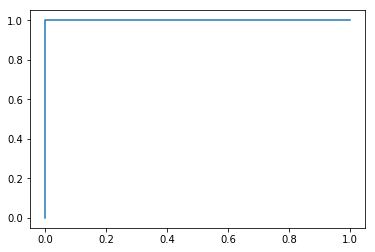

In [417]:
fpr, tpr, thresholds = metrics.roc_curve(train_Y, y_pred_train_xgboost)
auc = metrics.roc_auc_score(train_Y, y_pred_train_xgboost)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))

In [418]:
np.percentile(y_pred_train_xgboost,90)

0.7588539481163022

In [419]:
# df[num_train:][all_num_features]
# y_pred_test_xgboost = [1 if i >0.4 else 0 for i in y_pred_test_xgboost]

In [420]:
def output_prediction(predicitons,file_name,use_proba=True,threshold=None):
    if threshold==None:
        threshold = np.percentile(predicitons,50)
    predictions_pd = pd.DataFrame({'name':df[num_train:]['name'].values,'poi':predicitons})
    if use_proba==False:
        predictions_pd['poi'] = predictions_pd.poi.apply(lambda x: 1 if x>=threshold else 0)
    predictions_pd.loc[predictions_pd.name=='TOTAL','poi'] = 0
    predictions_pd.to_csv(file_name,index=False)
    return predictions_pd
# prediction

In [421]:
predictions_pd = output_prediction(y_pred_test_xgboost,'Day_051_053_predictions_xgboost_derived_ratios.csv',
                                   use_proba=True,threshold=None)

In [422]:
np.percentile(predictions_pd.poi,50)

0.03467394784092903

In [423]:
# predictions_pd['is_poi'] = predictions_pd.poi.apply(lambda x: 1 if x>=0.1055636927485466 else 0)
predictions_pd

,name,poi
0,BELDEN TIMOTHY N,0.801
1,BOWEN JR RAYMOND M,0.715
2,HANNON KEVIN P,0.911
3,DELAINEY DAVID W,0.237
4,CAUSEY RICHARD A,0.758
5,HICKERSON GARY J,0.154
6,FREVERT MARK A,0.980
7,CHAN RONNIE,0.003
8,DONAHUE JR JEFFREY M,0.289
9,REYNOLDS LAWRENCE,0.012


In [335]:
new_train['poi'] = train_Y
new_train['y_pred_train_xgboost'] = y_pred_train_xgboost

/Users/ttyoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ttyoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [325]:
y_pred_test_xgboost = model.predict_proba(df[num_train:][num_features])
y_pred_test_xgboost = [value[1] for value in y_pred_test_xgboost]

In [326]:
new_test['y_pred_test_xgboost'] = y_pred_test_xgboost

/Users/ttyoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [342]:
y_train_pred_cols = ['y_train_pred_proba_knn','y_train_pred_proba_rf','y_pred_train_xgboost']

In [343]:
new_train['min_pred'] = new_train[y_train_pred_cols].apply(lambda x: x.min(),axis=1)
new_train['max_pred'] = new_train[y_train_pred_cols].apply(lambda x: x.max(),axis=1)

/Users/ttyoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ttyoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [55]:
# new_train[['name','y_train_pred_proba_knn','y_train_pred_proba_rf','y_pred_train_xgboost','min_pred','max_pred','poi']]

In [363]:
from sklearn.tree import DecisionTreeClassifier

In [364]:
dt = DecisionTreeClassifier()

In [359]:
derived_cols = ['min_pred','max_pred']

In [365]:
dt.fit(new_train[y_train_pred_cols+derived_cols],train_Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [367]:
new_train['y_pred_train_dt'] = [i[1] for i in dt.predict_proba(new_train[y_train_pred_cols+derived_cols])]

/Users/ttyoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [368]:
new_train[['name']+y_train_pred_cols+derived_cols+['y_pred_train_dt','poi']]

,name,y_train_pred_proba_knn,y_train_pred_proba_rf,y_pred_train_xgboost,min_pred,max_pred,y_pred_train_dt,poi
0,RICE KENNETH D,0.800,0.863,0.921,0.800,0.921,1.000,True
1,SKILLING JEFFREY K,0.600,0.847,0.841,0.600,0.847,1.000,True
2,SHELBY REX,0.400,0.634,0.687,0.400,0.687,1.000,True
3,KOPPER MICHAEL J,0.200,0.699,0.719,0.200,0.719,1.000,True
4,CALGER CHRISTOPHER F,0.400,0.667,0.795,0.400,0.795,1.000,True
5,HIRKO JOSEPH,0.800,0.822,0.781,0.781,0.822,1.000,True
6,YEAGER F SCOTT,0.200,0.608,0.784,0.200,0.784,1.000,True
7,COLWELL WESLEY,0.400,0.790,0.940,0.400,0.940,1.000,True
8,LAY KENNETH L,0.800,0.889,0.899,0.800,0.899,1.000,True
9,GLISAN JR BEN F,0.200,0.731,0.742,0.200,0.742,1.000,True


In [339]:
new_test['min_pred'] = new_test[['y_test_pred_proba_knn','y_test_pred_proba_rf','y_pred_test_xgboost']].apply(lambda x: x.min(),axis=1)
new_test['max_pred'] = new_test[['y_test_pred_proba_knn','y_test_pred_proba_rf','y_pred_test_xgboost']].apply(lambda x: x.max(),axis=1)

/Users/ttyoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ttyoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [54]:
# new_test[['name','y_test_pred_proba_knn','y_test_pred_proba_rf','y_pred_test_xgboost','min_pred','max_pred']]
# y_test_pred_cols = ['y_test_pred_proba_knn','y_test_pred_proba_rf','y_pred_test_xgboost']

In [53]:
# new_test['y_pred_test_dt'] = [i[1] for i in dt.predict_proba(new_test[y_test_pred_cols+derived_cols])]

In [52]:
# new_test[['name']+y_test_pred_cols+derived_cols+['y_pred_test_dt']]

In [377]:
def adjusted_pred(pred,max_pred,min_pred):
    if max_pred>=0.5:
        return pred
    elif min_pred >=0.2:
        return max_pred
    else:
        return min_pred

In [379]:
new_test['final_pred'] = new_test.apply(lambda x:adjusted_pred(x.y_pred_test_dt,x.max_pred,x.min_pred),axis=1)

/Users/ttyoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [381]:
new_test[['name']+y_test_pred_cols+derived_cols+['y_pred_test_dt','final_pred']]

,name,y_test_pred_proba_knn,y_test_pred_proba_rf,y_pred_test_xgboost,min_pred,max_pred,y_pred_test_dt,final_pred
0,BELDEN TIMOTHY N,0.200,0.355,0.776,0.200,0.776,1.000,1.000
1,BOWEN JR RAYMOND M,0.400,0.393,0.282,0.282,0.400,1.000,0.400
2,HANNON KEVIN P,0.200,0.331,0.925,0.200,0.925,1.000,1.000
3,DELAINEY DAVID W,0.000,0.059,0.046,0.000,0.059,0.000,0.000
4,CAUSEY RICHARD A,0.400,0.445,0.706,0.400,0.706,1.000,1.000
5,HICKERSON GARY J,0.200,0.391,0.211,0.200,0.391,1.000,0.391
6,FREVERT MARK A,0.000,0.639,0.783,0.000,0.783,0.000,0.000
7,CHAN RONNIE,0.000,0.006,0.003,0.000,0.006,0.000,0.000
8,DONAHUE JR JEFFREY M,0.400,0.136,0.169,0.136,0.400,0.000,0.136
9,REYNOLDS LAWRENCE,0.000,0.063,0.036,0.000,0.063,0.000,0.000


In [391]:
new_test['y_pred_test_xgboost_adjusted'] = new_test['y_pred_test_xgboost'].apply(lambda x: 1 if x>=0.8 else x)

/Users/ttyoung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [392]:
predictions_pd = pd.DataFrame({'name':new_test.name.values,'poi':new_test.y_pred_test_xgboost_adjusted.values})
# prediction

In [393]:
# predictions_pd = predictions_pd[predictions_pd.name!='TOTAL']

In [394]:
predictions_pd.to_csv('enron_prediction_bxgboost_adjusted.csv',index=False)

In [395]:
predictions_pd

,name,poi
0,BELDEN TIMOTHY N,0.776
1,BOWEN JR RAYMOND M,0.282
2,HANNON KEVIN P,1.000
3,DELAINEY DAVID W,0.046
4,CAUSEY RICHARD A,0.706
5,HICKERSON GARY J,0.211
6,FREVERT MARK A,0.783
7,CHAN RONNIE,0.003
8,DONAHUE JR JEFFREY M,0.169
9,REYNOLDS LAWRENCE,0.036


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 22 columns):
name                         113 non-null object
bonus                        61 non-null float64
deferral_payments            28 non-null float64
deferred_income              34 non-null float64
director_fees                13 non-null float64
email_address                83 non-null object
exercised_stock_options      81 non-null float64
expenses                     73 non-null float64
from_messages                65 non-null float64
from_poi_to_this_person      65 non-null float64
from_this_person_to_poi      65 non-null float64
loan_advances                2 non-null float64
long_term_incentive          49 non-null float64
other                        69 non-null float64
poi                          113 non-null bool
restricted_stock             82 non-null float64
restricted_stock_deferred    10 non-null float64
salary                       73 non-null float64
shared_receipt_wi

In [7]:
test_X.head()

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,BELDEN TIMOTHY N,5249999.0,2144013.0,-2334434.0,NaN,tim.belden@enron.com,953136.0,17355.0,484.0,228.0,108.0,NaN,NaN,210698.0,157569.0,NaN,213999.0,5521.0,7991.0,5501630.0,1110705.0
1,BOWEN JR RAYMOND M,1350000.0,NaN,-833.0,NaN,raymond.bowen@enron.com,NaN,65907.0,27.0,140.0,15.0,NaN,974293.0,1621.0,252055.0,NaN,278601.0,1593.0,1858.0,2669589.0,252055.0
2,HANNON KEVIN P,1500000.0,NaN,-3117011.0,NaN,kevin.hannon@enron.com,5538001.0,34039.0,32.0,32.0,21.0,NaN,1617011.0,11350.0,853064.0,NaN,243293.0,1035.0,1045.0,288682.0,6391065.0
3,DELAINEY DAVID W,3000000.0,NaN,NaN,NaN,david.delainey@enron.com,2291113.0,86174.0,3069.0,66.0,609.0,NaN,1294981.0,1661.0,1323148.0,NaN,365163.0,2097.0,3093.0,4747979.0,3614261.0
4,CAUSEY RICHARD A,1000000.0,NaN,-235000.0,NaN,richard.causey@enron.com,NaN,30674.0,49.0,58.0,12.0,NaN,350000.0,307895.0,2502063.0,NaN,415189.0,1585.0,1892.0,1868758.0,2502063.0


In [8]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 21 columns):
name                         33 non-null object
bonus                        21 non-null float64
deferral_payments            11 non-null float64
deferred_income              15 non-null float64
director_fees                4 non-null float64
email_address                28 non-null object
exercised_stock_options      21 non-null float64
expenses                     22 non-null float64
from_messages                21 non-null float64
from_poi_to_this_person      21 non-null float64
from_this_person_to_poi      21 non-null float64
loan_advances                2 non-null float64
long_term_incentive          17 non-null float64
other                        24 non-null float64
restricted_stock             28 non-null float64
restricted_stock_deferred    8 non-null float64
salary                       22 non-null float64
shared_receipt_with_poi      21 non-null float64
to_messages         

In [ ]:

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y) 